In [1]:
import shap
shap.initjs()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'


import joblib, os

In [3]:
#load useful functions from other lessons for model creation and  evaluation
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

In [4]:
fname = "C:/Users/dell/Documents/Data Enrichment assignments/Sales-Prediction/best-models.joblib"
loaded_joblib = joblib.load(fname)

# Preview the contents of the loaded joblib objects
loaded_joblib.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'RandomForest', 'LinearRegression'])

In [5]:
X_train = loaded_joblib['X_train']
X_test = loaded_joblib['X_test']
y_train = loaded_joblib['y_train']
y_test = loaded_joblib['y_test']

preprocessor= loaded_joblib['preprocessor']
ran_for = loaded_joblib['RandomForest']
lin_reg= loaded_joblib['LinearRegression']

In [6]:
#Evaluate to make sure its good/ loaded correctly
evaluate_regression(ran_for,X_train,y_train, X_test,y_test)

In [7]:
evaluate_regression(lin_reg,X_train,y_train, X_test,y_test)
#both did

In [8]:
#check length of data to see how many rows
len(X_train)
#Lots of rows to handle so this will be sampled

6392

In [9]:
#its 6000 rows and we dont want too little so lets sample 500 
X_shap= shap.sample(X_train, nsamples = 500, random_state = SEED)
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Fat_Content_Regular  \
4469    -1.201325         0.159140 -1.023504                       1.0   
4438    -1.815803        -0.606211  0.388559                       0.0   
366     -1.123632         0.230603  1.884956                       1.0   
2219    -0.956475        -0.312724 -0.184640                       0.0   
6080    -1.467363         2.122053 -0.920256                       0.0   

      Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
4469                     0.0               1.0                  0.0   
4438                     0.0               0.0                  0.0   
366                      0.0               0.0                  0.0   
2219                     0.0               0.0                  0.0   
6080                     0.0               0.0                  0.0   

      Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  ...  \
4469               0.0              0.0                     0.0  ...   
4438               0.0              0.0                     0.0  ...   
366                0.0              0.0                     0.0  ...   
2219               0.0              0.0                     0.0  ...   
6080               0.0              0.0                     0.0  ...   

      Outlet_Size_MISSING  Outlet_Size_Medium  Outlet_Size_Small  \
4469                  0.0                 0.0                0.0   
4438                  0.0                 0.0                1.0   
366                   0.0                 0.0                1.0   
2219                  0.0                 1.0                0.0   
6080                  1.0                 0.0                0.0   

      Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
4469                          0.0                          0.0   
4438                          0.0                          1.0   
366                           0.0                          1.0   
2219                          1.0                          0.0   
6080                          0.0                          0.0   

      Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
4469                          1.0                        0.0   
4438                          0.0                        0.0   
366                           0.0                        0.0   
2219                          0.0                        0.0   
6080                          1.0                        1.0   

      Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
4469                            1.0                            0.0   
4438                            1.0                            0.0   
366                             1.0                            0.0   
2219                            1.0                            0.0   
6080                            0.0                            0.0   

      Outlet_Type_Supermarket Type3  
4469                            0.0  
4438                            0.0  
366                             0.0  
2219                            0.0  
6080                            0.0  

[5 rows x 41 columns]

In [10]:
y_shap = y_train.loc[X_shap.index]


In [11]:
y_shap

4469    1402.1748
4438    2120.5730
366     5153.2920
2219    2556.6720
6080      83.8908
          ...    
6181    4844.3608
717     1810.9760
6789    5932.2780
3608     302.9390
2472     188.4214
Name: Item_Outlet_Sales, Length: 500, dtype: float64

In [12]:
#Create model explainer
m_explainer = shap.Explainer(ran_for)
m_explainer

In [13]:
#Get shap values from data
shap_val = m_explainer(X_shap, y_shap)
type(shap_val)

shap._explanation.Explanation

In [14]:
shap_val.shape

(500, 41)

In [15]:
shap_val[0]

.values =
array([ 6.09701499e+01,  3.65390928e+01, -9.24530760e+02,  2.44598361e+01,
       -5.08311055e+00,  1.83489780e+01,  1.91362197e-01, -5.94211655e+00,
       -2.48896687e-01,  1.98064890e-01,  3.01089601e+00, -1.37913730e-01,
        1.51397933e+00,  3.95164943e+00,  5.09448270e-01, -8.04325490e-01,
       -2.72564109e-01, -1.44782811e+00,  1.95953936e-01, -4.96982462e-01,
        4.10748986e-02,  3.77372245e+00, -6.40354361e+00,  1.21972665e+00,
       -1.02638098e-01, -7.70791327e+01, -4.08721153e+00,  1.95339877e+00,
        2.14299095e+00, -1.62729896e+00,  7.34519633e+00, -1.81020542e+00,
        9.54892501e-01, -4.49125599e+00, -4.43525733e+00, -1.83131775e+01,
       -3.39282731e+01,  2.09162613e+02,  6.09352456e+00,  3.14324215e+00,
       -6.41125817e+01])

.base_values =
array([2154.71233664])

.data =
array([-1.20132496,  0.15914019, -1.02350384,  1.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.

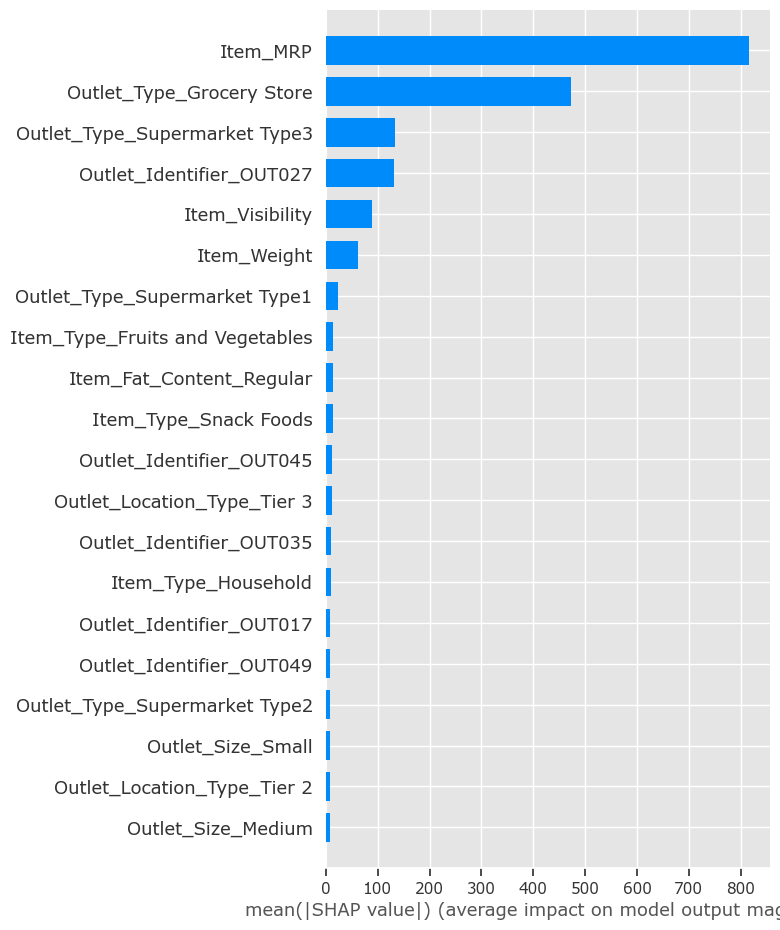

In [16]:
shap.summary_plot(shap_val,features= X_shap, plot_type='bar')

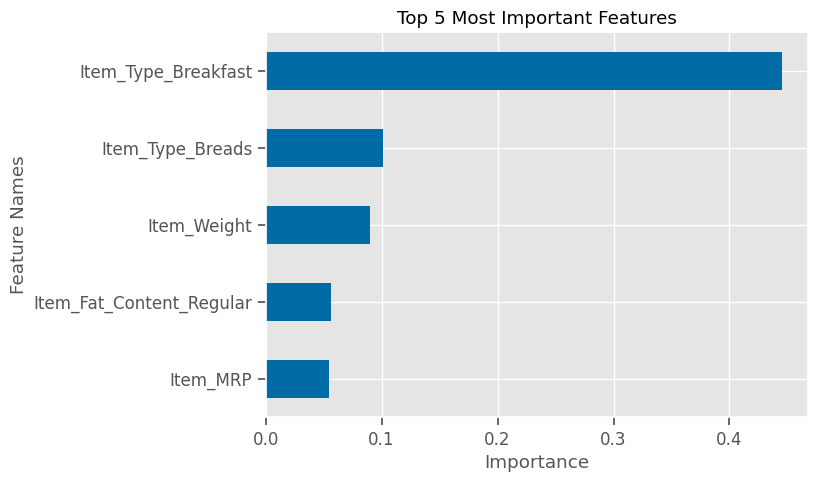

The features from shap vs feature importance my model are very different. they matched choosing Item mrp, item weight, and fat content regular but the importance/ impact is very different, for the shap values model item mrp is the most important vs on my feature importance model its the 5th most important. Item weight is the 6th most inmpactful in the shap values model but 3rd on my feature importance model. The also totally missed everything else. The feature importance model seems to have favored the categorical features more. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


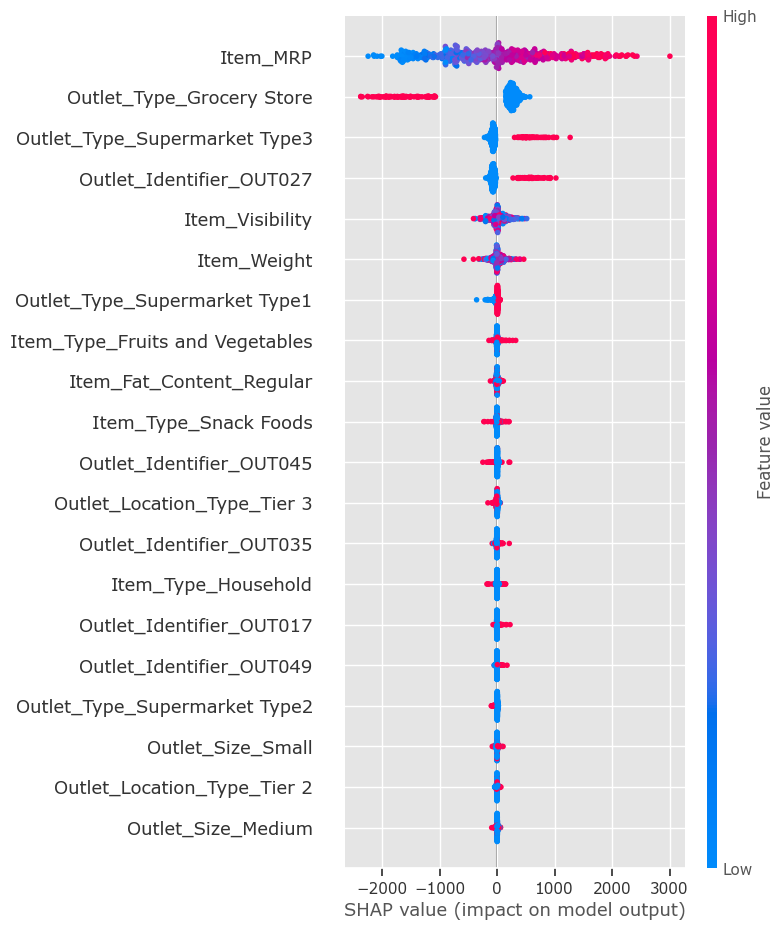

In [17]:
shap.summary_plot(shap_val,X_shap)
#default is dot model 

- For the first feature it seems with item mrp the higher it was it decreased sales. Vs the blue values were more to the left meaning that the mrp being lower increased sales 

- For grocery store if grocery store == 1 (its a grocery store) the model predicts the sales seem to have improved/ better. if grocery store == 0 the sales werent decreased but the model thought they werent as good as it would if it was  a grocery store. 

- Super market type 3 was predicted to have a negative impact on sales, it predicted sales were better when it was anything but market type 3== 0 and worse if it was == 1

In [18]:
import os
os.makedirs("images/", exist_ok=True)

# Local explanations 


- features im choosing are item mrp for high value target and outlet size medium

In [19]:
explainer_linreg= shap.Explainer(lin_reg, X_shap)
shap_vals_linreg = explainer_linreg(X_shap)
shap_vals_linreg.shape

(500, 41)

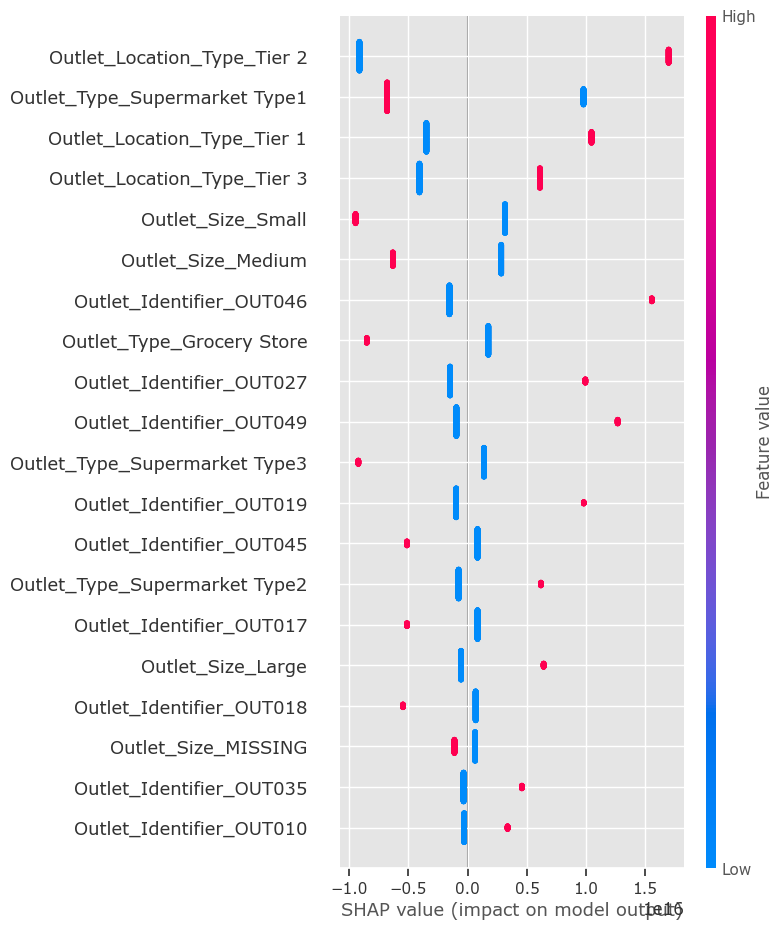

In [20]:
shap.summary_plot(shap_vals_linreg,features = X_shap)

In [21]:
X_slocal = X_shap.reset_index(drop = True)
y_slocal = y_shap.reset_index(drop = True)
X_slocal.head()

Item_Weight  Item_Visibility  Item_MRP  Item_Fat_Content_Regular  \
0    -1.201325         0.159140 -1.023504                       1.0   
1    -1.815803        -0.606211  0.388559                       0.0   
2    -1.123632         0.230603  1.884956                       1.0   
3    -0.956475        -0.312724 -0.184640                       0.0   
4    -1.467363         2.122053 -0.920256                       0.0   

   Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
0                     0.0               1.0                  0.0   
1                     0.0               0.0                  0.0   
2                     0.0               0.0                  0.0   
3                     0.0               0.0                  0.0   
4                     0.0               0.0                  0.0   

   Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  ...  \
0               0.0              0.0                     0.0  ...   
1               0.0              0.0                     0.0  ...   
2               0.0              0.0                     0.0  ...   
3               0.0              0.0                     0.0  ...   
4               0.0              0.0                     0.0  ...   

   Outlet_Size_MISSING  Outlet_Size_Medium  Outlet_Size_Small  \
0                  0.0                 0.0                0.0   
1                  0.0                 0.0                1.0   
2                  0.0                 0.0                1.0   
3                  0.0                 1.0                0.0   
4                  1.0                 0.0                0.0   

   Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
0                          0.0                          0.0   
1                          0.0                          1.0   
2                          0.0                          1.0   
3                          1.0                          0.0   
4                          0.0                          0.0   

   Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
0                          1.0                        0.0   
1                          0.0                        0.0   
2                          0.0                        0.0   
3                          0.0                        0.0   
4                          1.0                        1.0   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
0                            1.0                            0.0   
1                            1.0                            0.0   
2                            1.0                            0.0   
3                            1.0                            0.0   
4                            0.0                            0.0   

   Outlet_Type_Supermarket Type3  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0  

[5 rows x 41 columns]

In [22]:
X_slocal['Item_MRP'].describe()

count    500.000000
mean      -0.043356
std        0.995018
min       -1.734891
25%       -0.802439
50%        0.010784
75%        0.642089
max        2.018341
Name: Item_MRP, dtype: float64

In [23]:
idx_imrp = X_slocal['Item_MRP'].idxmax()
idx_imrp

431

In [24]:
X_slocal.iloc[idx_imrp]

Item_Weight                       -0.664539
Item_Visibility                   -0.778039
Item_MRP                           2.018341
Item_Fat_Content_Regular           0.000000
Item_Type_Baking Goods             0.000000
Item_Type_Breads                   0.000000
Item_Type_Breakfast                0.000000
Item_Type_Canned                   1.000000
Item_Type_Dairy                    0.000000
Item_Type_Frozen Foods             0.000000
Item_Type_Fruits and Vegetables    0.000000
Item_Type_Hard Drinks              0.000000
Item_Type_Health and Hygiene       0.000000
Item_Type_Household                0.000000
Item_Type_Meat                     0.000000
Item_Type_Others                   0.000000
Item_Type_Seafood                  0.000000
Item_Type_Snack Foods              0.000000
Item_Type_Soft Drinks              0.000000
Item_Type_Starchy Foods            0.000000
Outlet_Identifier_OUT010           0.000000
Outlet_Identifier_OUT013           0.000000
Outlet_Identifier_OUT017        

In [25]:
y_slocal.iloc[idx_imrp]

3171.8712

In [26]:
shap.force_plot(explainer_linreg.expected_value,
               shap_values= shap_vals_linreg[idx_imrp].values,
               features = X_slocal.iloc[idx_imrp])
#interesting itemMRP didnt even get chosen with linear regression model as being important/influencial 

In [27]:
#random forest force plot 
shap.force_plot(m_explainer.expected_value,
               shap_values= shap_val[idx_imrp].values,
               features = X_slocal.iloc[idx_imrp])

In [29]:
from lime.lime_tabular import LimeTabularExplainer
lime_explainer =LimeTabularExplainer(
    training_data=X_shap.values,  
    feature_names=X_shap.columns,
    #class_names=['low sales', 'high sales'], 
   mode='regression'
)
lime_explainer

In [30]:
exp= lime_explainer.explain_instance(X_slocal.iloc[idx_imrp],ran_for.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


# Observations/ interpretations
 - So the force plot and LIME are in agreement with the 2 positively  influential features of sales, however the amount of influence is not, they actually switch the values, lime thinking grocery store was more influential to the predictions, vs The forceplot thought item MRP was. The lower the Item mrp was, the more it positively influenced sales. And the outlet type not being a grocery store also influenced sales

In [31]:
X_slocal['Outlet_Size_Medium'].describe()

count    500.000000
mean       0.324000
std        0.468469
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Outlet_Size_Medium, dtype: float64

In [32]:
idx_med = X_slocal['Outlet_Size_Medium'].idxmax()
idx_med

3

In [33]:
X_slocal.iloc[idx_med]

Item_Weight                       -0.956475
Item_Visibility                   -0.312724
Item_MRP                          -0.184640
Item_Fat_Content_Regular           0.000000
Item_Type_Baking Goods             0.000000
Item_Type_Breads                   0.000000
Item_Type_Breakfast                0.000000
Item_Type_Canned                   0.000000
Item_Type_Dairy                    0.000000
Item_Type_Frozen Foods             0.000000
Item_Type_Fruits and Vegetables    0.000000
Item_Type_Hard Drinks              0.000000
Item_Type_Health and Hygiene       1.000000
Item_Type_Household                0.000000
Item_Type_Meat                     0.000000
Item_Type_Others                   0.000000
Item_Type_Seafood                  0.000000
Item_Type_Snack Foods              0.000000
Item_Type_Soft Drinks              0.000000
Item_Type_Starchy Foods            0.000000
Outlet_Identifier_OUT010           0.000000
Outlet_Identifier_OUT013           0.000000
Outlet_Identifier_OUT017        

In [34]:
y_slocal.iloc[idx_med]

2556.672

In [37]:
shap.force_plot(m_explainer.expected_value,
               shap_values= shap_val[idx_med].values,
               features = X_slocal.iloc[idx_med])

In [35]:
from lime.lime_tabular import LimeTabularExplainer
lime_explainer =LimeTabularExplainer(
    training_data=X_shap.values,  
    feature_names=X_shap.columns,
    #class_names=['low sales', 'high sales'], 
   mode='regression'
)
lime_explainer

In [36]:
expm= lime_explainer.explain_instance(X_slocal.loc[idx_med],ran_for.predict)
expm.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


# Observations 
When using outlet size medium samples outlet type supermarket type 3, outlet identifier 27 and a high mrp negatively influenced sales and is why outlet size medium was one of the least significant features. 
